# Understanding Transformers 

We will follow along with the tutorial by Andrej karpathy to understand the transformer architecture and create an LLM on the Shakespeare dataset "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

1. We will use the Pytorch library
2. We only work with chunks of the data at a time (batch training). The max length is suaully called block size or cntext length


In [1]:
# Open the file to inspect the data 
with open("input.txt", "r", encoding = "utf-8") as f:
    text = f.read()
    

In [2]:
print(len(text))
print(text[:1000])

1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for re

### 1. Tokenize and Encode

In [3]:
#Create a sorted list of all the unique characters in the input "text"
chars = sorted(list(set(text)))

#Vocab size is the total length of the unique tokens or characters (in this case)
vocab_size = len(chars)

print("".join(chars))
print(vocab_size ) #65


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# Create an enocder and decoder for character level tokenizer 
#(OpenAI has atiktoken library and google has sentencepiece library for tokenizing)

#Convert char to int dict (encode)
stoi = {ch:i for i, ch in enumerate(chars)}

#Convert int to char dict (encode)
itos = {i:ch for i, ch in enumerate(chars)}


encode = lambda s : [stoi[i] for i in s]
decode = lambda l : "".join([itos[i] for i in l])

print(encode("What's up?"))

[35, 46, 39, 58, 5, 57, 1, 59, 54, 12]


In [5]:
# Import the Pytorch Library, encode the dataset and save it in the form of a tensor
import torch


data = torch.tensor(encode(text), dtype = torch.long) #saves the data in the form of a 1D tensor

data.shape #torch.Size([1115394])



torch.Size([1115394])

### 2. Train test Split

In [6]:
# Set aside the last 10% of the data as the validation data and the remaining would be the train data. 
#We do not want memorization of this data, but rather Shakepeare like text

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

### 3. Create Batches of Data

In [7]:
# We only work with chunks of the data at a time (batch training). The max length is suaully called block size or cntext length
block_size = 8
train_data[: block_size + 1] 

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [8]:
#When we sample the chunk of data,they have mutliple samples packed into it.
#In a chunk of 9 chars, 8 individual examples are packed inside 
#This enables the model to make predictions when the input is as little as one character up to when the input size is equal to block_size 

x = train_data[:block_size ]
y = train_data[1:block_size + 1] # y is off-set by one, because the transformer predicts the next token

for t in range(block_size):
    context = x[: t+1]
    target = y[t]
    print(f"When input is {context}, the target {target}.")

When input is tensor([18]), the target 47.
When input is tensor([18, 47]), the target 56.
When input is tensor([18, 47, 56]), the target 57.
When input is tensor([18, 47, 56, 57]), the target 58.
When input is tensor([18, 47, 56, 57, 58]), the target 1.
When input is tensor([18, 47, 56, 57, 58,  1]), the target 15.
When input is tensor([18, 47, 56, 57, 58,  1, 15]), the target 47.
When input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target 58.


In [9]:
torch.manual_seed(1337)
batch_size = 4 #Number of training sequences to run in parallel
block_size = 8 #Max length of the sequence

def get_batch(split):

    data = train_data if split=="train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix]) #Stack multiple examples in the form of a tensor
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y


#32 examples packed in a tensor of size batch_size X block_size
xb, yb = get_batch("train")
print("Inputs:") #Input to our transformer 
print(xb)
print("Targets:")
print(yb)


for i in range(batch_size): #batch dimension
    for t in range(block_size): #time dimension
        context = xb[i,: t+1]
        target = yb[i, t]
        print(f"When input is {context.tolist()}, the target {target}.")


Inputs:
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
Targets:
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
When input is [24], the target 43.
When input is [24, 43], the target 58.
When input is [24, 43, 58], the target 5.
When input is [24, 43, 58, 5], the target 57.
When input is [24, 43, 58, 5, 57], the target 1.
When input is [24, 43, 58, 5, 57, 1], the target 46.
When input is [24, 43, 58, 5, 57, 1, 46], the target 43.
When input is [24, 43, 58, 5, 57, 1, 46, 43], the target 39.
When input is [44], the target 53.
When input is [44, 53], the target 56.
When input is [44, 53, 56], the target 1.
When input is [44, 53, 56, 1], the target 58.
When input is [44, 53, 56, 1, 58], the target 46.
When input is [44, 53, 56, 1, 58, 46], the target 3

## Modelling

### i. Bigram Model
The embedding matrix in the bigram model in a vocab_size * vocab_size matrix. For a given input, it simply plucks out the corresponding row from the embedding table. The values in that row corresponds to the probabilities of each of the vocab element to come next.

The predictions are based solely on the current token.

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        #Each token reads off the logits for the next token from a look up table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) 

    def forward(self, idx, targets = None):

        #idx and targets, both are (B,C) tensors. 
        #For each of these tokens, we will get a vocab_size "C" logit, and the output shape would be (B, T, C) 
        logits = self.token_embedding_table(idx) #output shape: (B, T, C)

        if targets==None:
            loss = None

        else:
        #Pytorch expects the input for this loss function to be of shape (B, C, T), so we need to reshape our logit matrix
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)    # -log likelihood loss
        
        return logits, loss


    #Generate new text
    #This function takes in the entire context, even though the bigram model only needs the last index for th enext prediction. 
    #We do this so that this function can be kept constant for more complicated models.
    def generate(self, idx, max_new_tokens):

        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):

            #Get the predictions
            logits, loss = self(idx)

            # Outputs (B, T, C) Pluck the last entry in the T dimension for the next prediction
            logits = logits[:,-1, :] #(B, C)

            #Apply softmax to get the probabilities
            probs = F.softmax(logits, dim=-1) #(B, C)
            
            #sample from distribution
            idx_next = torch.multinomial(probs, num_samples = 1) #(B, 1)
            
            #Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim = 1) #(B, T+1)
            
        return idx


            
            
model = BigramLanguageModel(vocab_size)
logits, loss = model(xb, yb)
print(loss)  
start = torch.zeros((1,1), dtype = torch.long)
print(decode(model.generate(start, max_new_tokens = 100)[0] .tolist()))


tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [11]:
#Create a pytorch optimizer to train the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #Good learning rate for larger models can be 3e-4 etc. 

2.382369041442871


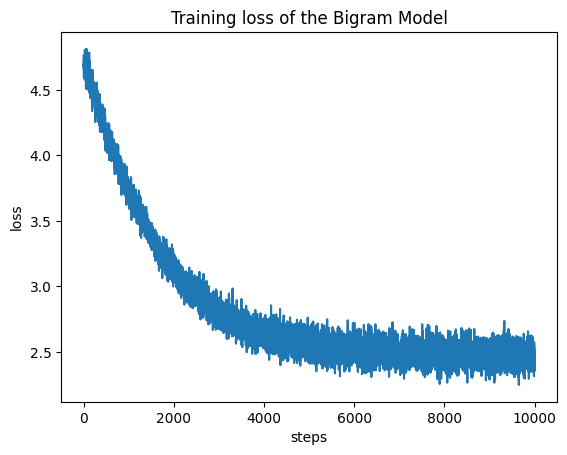

In [12]:
import matplotlib.pyplot as plt

train_loss_curve = []

batch_size = 32
n_steps = 10000 #Train for 10,000 steps

for _ in range(n_steps):
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
    train_loss_curve.append(loss.item())


plt.plot(train_loss_curve)
plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Training loss of the Bigram Model")

print(loss.item())  

In [13]:
#Generate from the trained model
start = torch.zeros((1,1), dtype = torch.long)
print(decode(model.generate(start, max_new_tokens = 500)[0] .tolist()))

#Great improvement from the untrained model, but we can do better


lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


### The Mathematical Trick in Self-Attention

We would like the tokens to interact with each other. But this communication should be one-way
Information only flows from previous to the current time-step. No information flows from the future, because we want to predict the future.
One way is to average the C dimension of all the tokens in context.
This averaging or summation would be extremely lossy because we have lost all information about the relative location of all the tokens.
 
We use the term Bag of words (BOW) when we are averaging a group of words. 

In [14]:
# Take a toy example
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
print(x.shape)

torch.Size([4, 8, 2])


In [15]:
# 1 

xbow  = torch.zeros(B, T, C)
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] #(t, C)
        xbow[b, t] = torch.mean(xprev, 0)

print(x[0])
print(xbow[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [16]:
torch.manual_seed(43)
a = torch.tril(torch.ones(3,3))
a = a / a.sum(1, keepdim = True)
b = torch.randint(0, 10, (3,2)).float() # If we do not convert to float, it will give a runtime error
c = a @ b
print(f"a : {a}")
print(f"b : {b}")
print(f"c : {c}")


a : tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b : tensor([[8., 8.],
        [5., 7.],
        [5., 0.]])
c : tensor([[8.0000, 8.0000],
        [6.5000, 7.5000],
        [6.0000, 5.0000]])


In [17]:
#Version 2 
#Converting cell 1 to matrix operation
w = torch.tril(torch.ones(T, T))
w = w / w.sum(1, keepdim = True)
# Pytorch will see that the dimenisons do not match and will create a batch dimension
xbow2 = w @ x # (B, T, T) * ( B, T, C)  ---> (B, T, C)
torch.allclose(xbow, xbow2) #Both are equal. 
#This is a weighted sum according to the weight matrix w

True

In [18]:
# Version 3
w = torch.zeros((T, T))
tril = torch.tril(torch.ones(T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim = -1)
xbow3 = w @ x
torch.allclose(xbow3, xbow)

True

In [29]:
# Version 4 Self-attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32 #batch, time, channels
x = torch.randn(B, T, C)

#Previosuly the different tokens were interacting through simple average. 
#However, each token might find different tokens from its context interesting and we want that info to flow to the curretn token.
#For that, each token in the context will emit two vectors, a query and a key. The query says what I am looking for, and the key says what I can offer.
#To find affinitites, then we find the dot product of the query of each token to the key of eveything else, and that dot product would be the wei/w matrix in our case.
# if the keys and queries of two tokens align, they will output to a very high value

#Let's see a single head perform self attention
head_size = 16
query = nn.Linear(C, head_size, bias = False) #bias is False because it is a simple matrix multiplication operation
key = nn.Linear(C, head_size, bias = False)

#When we do the agrregation, we don't actually ggregate the tokens, we bring one more component, "value"
value = nn.Linear(C, head_size, bias = False)

 
k = key(x) #(B, T, head_size)
q = query(x) #(B, T, head_size)


#To communication, all the queries will communicate with all the keys
w = q @ k.transpose(-2, -1)  #(B, T, 16) * (B, 16, T) ---> (B, T, T)

# We use a lower traingular masking because we do not want any information to flow from future to the present or past (This is the decoder structure)
#This tril matrix differentiates an encoder from a decoder. In an encoder, all tokens can communicate, so this is no masking.
#Attention does not care, it allows for arbitrary communication between tokens. 
tril = torch.tril(torch.ones(T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim = -1) #exponentiate and normalize (to get rid of negatives and to make them sum to 1)

#v is the vector that we aggregate, instead of the raw head
# The information in x is somewhat private to the token. The value v is what the token is willing to communicate to the other tokens
v = value(x) #(B, T, head_size)

out = w @ v #(B, T, T) X (B, T, head_size) ---> (B, T, head_size) 
print(out.shape)

torch.Size([4, 8, 16])


#### Notes:

In self-attention, keys, values and queries come from the same source. In "cross-attention", there is a separate source for keys and values than the queries. 
We also divide by the square root of head_size. They call it scaled attention. This is because if we have unit Gaussian inputs (0 mean 1 variance) and we do wei naively, its variance will be on the order of the head_size. Normalizing it will bring the variance back to 1. 

The problems is if wei takes high negative and/or negative, the wei will sharpen towards the max when softmax is applied. In other words, this scaling helps diffuse the wei matrix and reduce the variance. It is because when we apply the softmax, the softmax tends to converge to the extremes. This will likely converge the wei matrix to one-hot matrix, where information is only flowing from one vector. This is not what we want, especially at initialization. 

We apply the following regularization techniques:

1. Dropout
2. Layer Normalization
3. Skip connections (for exploding and vansihing gradient problems in deeper networks) 

In [58]:
!python transformer.py 

Total number of parameters in the model:  10.693697 million
Total number of tokens used for the model's training: 1.115394 million
Iteration number: 0, train_loss: 4.3636, val_loss: 4.3572
Iteration number: 300, train_loss: 2.1705, val_loss: 2.2422
Iteration number: 600, train_loss: 2.0453, val_loss: 2.1573
Iteration number: 900, train_loss: 1.9785, val_loss: 2.1038
Iteration number: 1200, train_loss: 1.9290, val_loss: 2.0867
Iteration number: 1500, train_loss: 1.9060, val_loss: 2.0548
Iteration number: 1800, train_loss: 1.8753, val_loss: 2.0375
Iteration number: 2100, train_loss: 1.8639, val_loss: 2.0392
Iteration number: 2400, train_loss: 1.8489, val_loss: 2.0160
Iteration number: 2700, train_loss: 1.8373, val_loss: 2.0047
Iteration number: 3000, train_loss: 1.8163, val_loss: 1.9982
Iteration number: 3300, train_loss: 1.8099, val_loss: 1.9824
Iteration number: 3600, train_loss: 1.7941, val_loss: 1.9669
Iteration number: 3900, train_loss: 1.7875, val_loss: 1.9594
Iteration number: 420